In [3]:
import tensorflow as tf
%matplotlib inline

/Users/dosya/Projects/lab_iis/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("telemetrika_db.csv", header=0)

In [5]:
list(df.columns)

['uid',
 'bv_number',
 'speed',
 'load',
 'amount',
 'image_name',
 'date',
 'point',
 'time',
 'id']

In [6]:
clean_df = df.drop(['uid', 'image_name', 'id'], axis=1)

In [7]:
clean_df['time'] = clean_df['time'].floordiv(1000)
clean_df_old = clean_df.copy()

In [8]:
clean_df[:10]

,bv_number,speed,load,amount,date,point,time
0,2,64,1,75,2016-07-09 16:11:59+06,6,1468059119
1,2,30,8,255,2016-07-09 16:12:35+06,1,1468059155
2,2,17,2,50,2016-07-09 16:13:10+06,9,1468059190
3,2,83,1,118,2016-07-09 16:13:45+06,4,1468059225
4,2,38,5,192,2016-07-09 16:14:21+06,8,1468059261
5,2,83,3,250,2016-07-09 16:14:56+06,4,1468059296
6,2,10,15,158,2016-07-09 16:15:31+06,9,1468059331
7,2,33,8,279,2016-07-09 16:16:07+06,8,1468059367
8,2,25,10,257,2016-07-09 16:16:42+06,9,1468059402
9,2,60,1,117,2016-07-09 16:17:17+06,1,1468059437


In [9]:
from datetime import datetime, timedelta
end_datetime = clean_df['time'].max()
begin_datetime = clean_df['time'].min()
print(begin_datetime, 'to', end_datetime)

1468059119 to 1527164748


In [10]:
weather_df = pd.read_excel("weather.xlsx")

In [11]:
clean_weather_df = weather_df[['Местное время в Алматы', 'T', 'W1', 'RRR', 'sss']]

In [12]:
clean_weather_df = clean_weather_df.replace(np.nan, 0)

In [13]:
weather_states = [
    'Туман или ледяной туман или сильная мгла.',
    'Снег или дождь со снегом.',
    'Ливень (ливни).',
    'Ливни или перемещающиеся осадки.',
    'Дождь.',
    'Осадки',
    'Явление, связанное с переносом ветром твердых частиц, видимость пониженная.',
    'Гроза (грозы) с осадками или без них.',
    'Морось.',
    'Облака покрывали более половины неба в течение всего соответствующего периода.',
    'Облака покрывали более половины неба в течение одной части соответствующего периода и половину или менее в течение другой части периода.',
    'Облака покрывали половину неба или менее в течение всего соответствующего периода.'
]

for i, v in enumerate(weather_states):
    clean_weather_df['W1'] = clean_weather_df['W1'].replace(v, 100-(i*8))

In [14]:
clean_weather_df['RRR'] = clean_weather_df['RRR'].replace("Следы осадков", 1.0)
clean_weather_df['sss'] = clean_weather_df['sss'].replace("Менее 0.5", 0.5)
clean_weather_df['sss'] = clean_weather_df['sss'].replace("Снежный покров не постоянный.", 0.3)

In [15]:
import time
clean_weather_df['Местное время в Алматы'] = pd.to_datetime(clean_weather_df['Местное время в Алматы'])
clean_weather_df['Местное время в Алматы'] = [int(time.mktime(i.timetuple())) for i in clean_weather_df['Местное время в Алматы']]

In [16]:
clean_weather_df[:10]

,Местное время в Алматы,T,W1,RRR,sss
0,1527174000,12.0,0,0.0,0.0
1,1527163200,14.5,0,0.0,0.0
2,1527152400,15.2,0,0.0,0.0
3,1527141600,13.2,0,11.0,0.0
4,1527130800,10.5,0,11.0,0.0
5,1527120000,5.0,0,0.0,0.0
6,1527109200,5.0,84,0.0,0.0
7,1527098400,4.8,44,20.0,0.0
8,1527087600,5.8,44,20.0,0.0
9,1527076800,12.2,44,0.0,0.0


In [17]:
weather_matrix_data = []
for i in list(clean_weather_df.columns):
    smooth = []
    for j, v in enumerate(clean_weather_df[i][1:]):
        smooth.extend(list(map(int, np.linspace(v, clean_weather_df[i][j], num=4))))
    if i == "Местное время в Алматы":
        smooth = list(map(datetime.fromtimestamp, smooth))
    weather_matrix_data.append(smooth)

In [18]:
weather_matrix = np.array(list(zip(*weather_matrix_data)))

In [19]:
x_train = clean_df.as_matrix()

In [20]:
new_weather_df = pd.DataFrame(weather_matrix, columns=['date', 'temperature', 'weather', 'rain', 'snow']) 
new_weather_df['date'] = pd.to_datetime(new_weather_df['date'])

In [21]:
new_weather_df = new_weather_df.drop_duplicates()

In [22]:
clean_df['date'] = pd.to_datetime(clean_df['date'])
clean_df['date'] = clean_df['date'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour))

In [23]:
merge = clean_df.merge(new_weather_df, on='date', how='inner')

In [24]:
merge['date'] = pd.to_datetime(clean_df_old['date'])

In [25]:
merge['month'] = list(merge['date'].apply(lambda dt: int(dt.month)))

In [26]:
import numpy as np

In [27]:
merge['weekday'] = list(merge['date'].apply(lambda dt: np.eye(7)[int(dt.weekday())]))

In [28]:
merge['chunk'] = list(merge['date'].apply(lambda dt: int((dt.hour*60+dt.minute)/10)))

In [29]:
merge = merge.drop(['date', 'time'], axis=1)

In [30]:
weekday = pd.DataFrame(list(merge["weekday"]), columns='Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split())

In [31]:
merge = pd.concat([merge, weekday],axis=1)

In [32]:
merge.drop("weekday", axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105b7e240>,
      dtype=object)

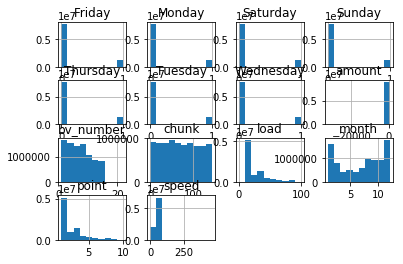

In [33]:
merge.to_csv("preprocessed.csv")
merge.hist()

In [42]:
x_train, y_train = merge.drop(["load", "amount"],axis=1).as_matrix(), merge[["load", "amount"]].as_matrix()
x_train.shape, y_train.shape

((8841960, 16), (8841960, 2))

In [55]:
train_length = len(x_train)
test_length = len(y_train)
features_length = x_train.shape[1]

In [56]:
n_nodes_hl1 = 20
n_nodes_hl2 = 15
n_nodes_hl3 = 10

In [57]:
x = tf.placeholder('float', [None, features_length])
y = tf.placeholder('float', [None, 2])

In [58]:
def neural_network_model(data):
    hidden_l1 = {'weights': tf.Variable(tf.random_normal([features_length, n_nodes_hl1])),
                 'biases': tf.Variable(tf.random_normal([n_nodes_hl1]))}
    
    hidden_l2 = {'weights': tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                 'biases': tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_l3 = {'weights': tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                 'biases': tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_l = {'weights': tf.Variable(tf.random_normal([n_nodes_hl3, 1])),
                'biases': tf.Variable(tf.random_normal([1]))}

    l1 = tf.add(tf.matmul(data, hidden_l1['weights']), hidden_l1['biases'])
    l1 = tf.nn.sigmoid(l1) # maybe sigmoid

    l2 = tf.add(tf.matmul(l1, hidden_l2['weights']), hidden_l2['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2, hidden_l3['weights']), hidden_l3['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.add(tf.matmul(l3, output_l['weights']), output_l['biases'])
    return output

In [83]:
def train_neural_network(x):
    prediction = neural_network_model(x)
#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)) 
#     cost = tf.losses.mean_squared_error(labels=y, predictions=prediction)
    cost = tf.reduce_mean(tf.squared_difference(prediction, y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)
    epochs_no = 200
 
    gpu_options = tf.GPUOptions(allow_growth=True)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
  
        # training
        for epoch in range(epochs_no):
            epoch_x = x_train[:-20]
            epoch_y = y_train[:-20]
            _, c = sess.run([optimizer, cost], feed_dict = {x: epoch_x, y: epoch_y})
            print('Epoch', epoch, 'completed out of', epochs_no, "cost:", c)
  
        # testing
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:', accuracy.eval({x: x_train[-20:], y: y_train[-20:]}))
#         tests = sess.run([prediction], feed_dict={x: features_for_testing})
#         print(tests, np.array(tests).shape)
    sess.close()

In [ ]:
train_neural_network(x)

In [ ]:
prediction = neural_network_model(x)
#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)) 
#     cost = tf.losses.mean_squared_error(labels=y, predictions=prediction)
# cost = tf.reduce_mean(tf.squared_difference(prediction, y))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)
# epochs_no = 50
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print(x_train[-20:])
#     print(y_train[-20:])
#     tests = sess.run(prediction, feed_dict={x: x_train[-20:]})
#     print(tests, np.array(tests).shape)
#     sess.close()

In [1]:
# merge

NameError: name 'merge' is not defined